In [ ]:
# --- Loan Approval Prediction with SMOTE, Logistic Regression & Decision Tree ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ---------------- Load Dataset ----------------
df = pd.read_csv("/content/loan_approval_dataset.csv")  # <-- replace with your file path

# Normalize column names (remove spaces, lowercase)
df.columns = df.columns.str.strip().str.lower()

print("Columns in dataset:", df.columns.tolist())

# ---------------- Target Column ----------------
# Detect column containing 'loan_status'
if "loan_status" in df.columns:
    target = "loan_status"
else:
    # fallback: last column
    target = df.columns[-1]

print("Using target column:", target)

y = df[target]

# Map target to 0/1
y = y.map(lambda v: 1 if str(v).strip().lower() in ['y','yes','approved','1'] else 0)

X = df.drop(columns=[target])

# ---------------- Feature Types ----------------
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

# ---------------- Preprocessing ----------------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# ---------------- Train-Test Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print("\nTrain distribution:\n", y_train.value_counts())
print("Test distribution:\n", y_test.value_counts())

# ---------------- Baseline Logistic Regression (no SMOTE) ----------------
baseline_pipe = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

baseline_pipe.fit(X_train, y_train)
y_pred_baseline = baseline_pipe.predict(X_test)

print("\n--- Baseline Logistic Regression (No SMOTE) ---")
print(confusion_matrix(y_test, y_pred_baseline))
print(classification_report(y_test, y_pred_baseline, digits=4))

# ---------------- Logistic Regression + SMOTE ----------------
pipe_lr = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

print("\n--- Logistic Regression + SMOTE ---")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, digits=4))

# ---------------- Decision Tree + SMOTE ----------------
pipe_dt = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(random_state=42))
])

pipe_dt.fit(X_train, y_train)
y_pred_dt = pipe_dt.predict(X_test)

print("\n--- Decision Tree + SMOTE ---")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt, digits=4))

# ---------------- Feature Importance (Decision Tree) ----------------
# Get feature names
ohe = pipe_dt.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot']
ohe_features = ohe.get_feature_names_out(cat_cols)
feature_names = num_cols + list(ohe_features)

importances = pipe_dt.named_steps['clf'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(15)

print("\n--- Top 15 Feature Importances (Decision Tree) ---")
print(feat_imp)



Columns in dataset: ['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']
Using target column: loan_status

Train distribution:
 loan_status
1    2125
0    1290
Name: count, dtype: int64
Test distribution:
 loan_status
1    531
0    323
Name: count, dtype: int64

--- Baseline Logistic Regression (No SMOTE) ---
[[281  42]
 [ 32 499]]
              precision    recall  f1-score   support

           0     0.8978    0.8700    0.8836       323
           1     0.9224    0.9397    0.9310       531

    accuracy                         0.9133       854
   macro avg     0.9101    0.9049    0.9073       854
weighted avg     0.9131    0.9133    0.9131       854


--- Logistic Regression + SMOTE ---
[[301  22]
 [ 41 490]]
              precision    recall  f1-score   support

           0     0.8801    0.9319    0.9053


--- Logistic Regression + SMOTE ---
              precision    recall  f1-score   support

           0     0.8801    0.9319    0.9053       323
           1     0.9570    0.9228    0.9396       531

    accuracy                         0.9262       854
   macro avg     0.9186    0.9273    0.9224       854
weighted avg     0.9279    0.9262    0.9266       854



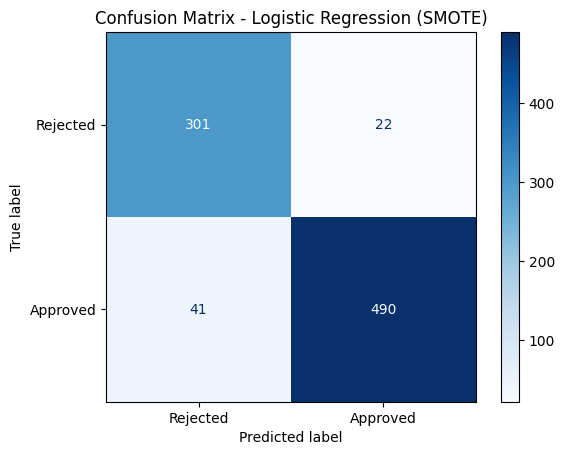


--- Decision Tree + SMOTE ---
              precision    recall  f1-score   support

           0     0.9689    0.9659    0.9674       323
           1     0.9793    0.9812    0.9802       531

    accuracy                         0.9754       854
   macro avg     0.9741    0.9736    0.9738       854
weighted avg     0.9754    0.9754    0.9754       854



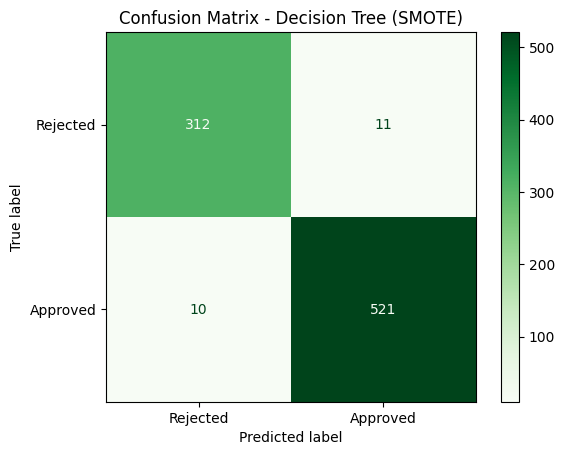

/tmp/ipython-input-752815764.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")


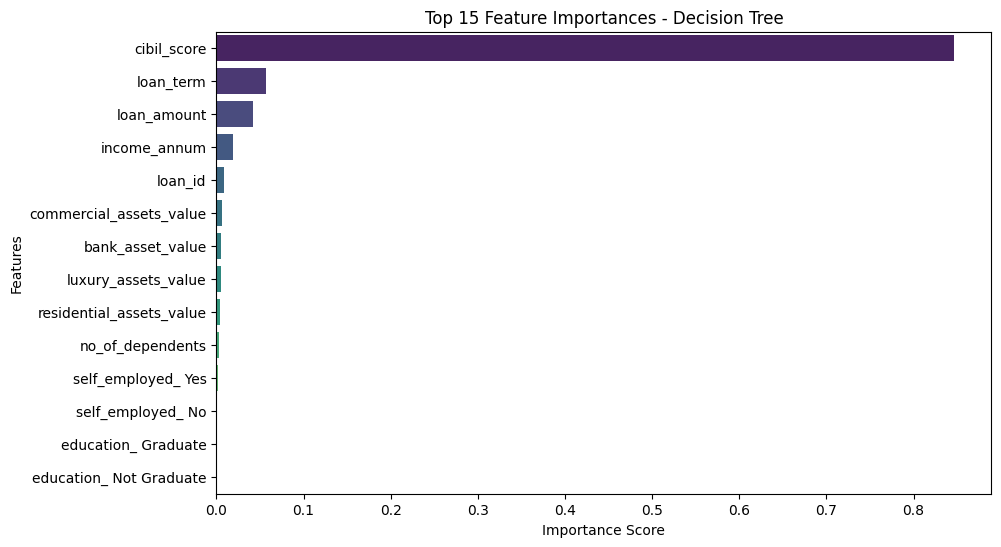

In [1]:
# --- Loan Approval Prediction with SMOTE, Logistic Regression & Decision Tree (with Plots) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ---------------- Load Dataset ----------------
df = pd.read_csv("/content/loan_approval_dataset.csv")  # <-- replace with your file path

# Normalize column names (remove spaces, lowercase)
df.columns = df.columns.str.strip().str.lower()

# ---------------- Target Column ----------------
target = "loan_status" if "loan_status" in df.columns else df.columns[-1]
y = df[target]

# Map target to 0/1
y = y.map(lambda v: 1 if str(v).strip().lower() in ['y','yes','approved','1'] else 0)
X = df.drop(columns=[target])

# ---------------- Feature Types ----------------
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

# ---------------- Preprocessing ----------------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# ---------------- Train-Test Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# ---------------- Logistic Regression + SMOTE ----------------
pipe_lr = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

print("\n--- Logistic Regression + SMOTE ---")
print(classification_report(y_test, y_pred_lr, digits=4))

# Plot Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["Rejected","Approved"])
disp_lr.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression (SMOTE)")
plt.show()

# ---------------- Decision Tree + SMOTE ----------------
pipe_dt = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(random_state=42))
])

pipe_dt.fit(X_train, y_train)
y_pred_dt = pipe_dt.predict(X_test)

print("\n--- Decision Tree + SMOTE ---")
print(classification_report(y_test, y_pred_dt, digits=4))

# Plot Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["Rejected","Approved"])
disp_dt.plot(cmap="Greens")
plt.title("Confusion Matrix - Decision Tree (SMOTE)")
plt.show()

# ---------------- Feature Importance (Decision Tree) ----------------
ohe = pipe_dt.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot']
ohe_features = ohe.get_feature_names_out(cat_cols)
feature_names = num_cols + list(ohe_features)

importances = pipe_dt.named_steps['clf'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(15)

# Plot Feature Importance
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")
plt.title("Top 15 Feature Importances - Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()
